In [1]:
# Init
import glob
import os
import pickle
import sys

module_path = os.path.abspath(os.path.join("../src/simulicronalpha/"))
if module_path not in sys.path:
    sys.path.append(module_path)

import multiprocessing
import warnings

# Imports
import numpy as np
import pandas as pd

np.set_printoptions(suppress=True)
# For loading data
import concurrent.futures
import gc
import json
import random

# Plotting imports
import altair as alt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import figure
from numpy import concatenate as c
from numpy import cumsum

In [2]:
# Acc. functions
def returnLast(lst):
    return lst[-1]


def returnGen(lst):
    return lst[1500]


def returnList(HGTGen, lst):
    return lst[HGTGen]


def colorRanges(i):
    # Construct the colormap
    current_palette = sns.color_palette("muted", n_colors=5)
    cmap = ListedColormap(sns.color_palette(current_palette).as_hex())
    # range and stuff
    if i == 0:
        return "0"
    elif i > 0 and i <= 20:
        return "1-20"
    elif i > 20 and i <= 50:
        return "20-50"
    elif i > 50 and i <= 100:
        return "50-100"
    elif i > 100 and i <= 200:
        return "100-200"
    elif i > 200 and i <= 300:
        return "200-300"
    elif i > 300:
        return ">300"


# Since pickle format is not working as intended.
# Insert angry thoughts abouts pickle format here
# A function to open pickle files and convert into json
def pickleToJson(resultDir):
    for file in glob.glob(os.path.join(resultDir, "*.pickle")):
        with open(file, "rb") as f:
            # print ("Converting file : " + file)
            gc.disable()
            data = pickle.load(f)
            del data["TEset"]
            del data["NTE"]
            del data["NTI"]
            del data["AvgFit"]
            del data["Freq"]
            gc.enable()
            with open(file + ".json", "w") as fp:
                json.dump(data, fp)
    return 0


def bin_by(x, y, nbins=30, bins=None):
    if bins is None:
        bins = np.linspace(x.min(), x.max(), nbins)

    bin_space = (bins[-1] - bins[0]) / (len(bins) - 1) / 2

    indicies = np.digitize(x, bins + bin_space)

    output = []
    for i in range(0, len(bins)):
        output.append(y[indicies == i])
    #
    # prepare a dataframe with cols: median; mean; 1up, 1dn, 2up, 2dn, 3up, 3dn
    df_names = ["mean", "median", "5th", "95th", "10th", "90th", "25th", "75th"]
    df = pd.DataFrame(columns=df_names)
    to_delete = []
    # for each bin, determine the std ranges
    for y_set in output:
        if y_set.size > 0:
            av = y_set.mean()
            intervals = np.percentile(y_set, q=[50, 5, 95, 10, 90, 25, 75])
            res = [av] + list(intervals)
            df = df.append(pd.DataFrame([res], columns=df_names))
        else:
            # just in case there are no elements in the bin
            to_delete.append(len(df) + 1 + len(to_delete))

    # add x values
    bins = np.delete(bins, to_delete)
    df["x"] = bins

    return df


def dfWrangler(dataFrame):
    # Perform some data wrangling
    dataFrame[["TranspositionRate_1", "TranspositionRate_2"]] = pd.DataFrame(
        dataFrame.TRate.tolist(), index=dataFrame.index
    )
    dataFrame[["TE_1_CN", "TE_2_CN"]] = dataFrame["TEfamilyCN"].apply(pd.Series)
    dataFrame[["TE_1_RG", "TE_2_RG"]] = dataFrame["TEfamilyRg"].apply(pd.Series)
    dataFrame[["TE_1_pi", "TE_2_pi"]] = dataFrame["TEpi"].apply(pd.Series)

    # Add column for the last acn (average copy number) for each transposon family
    dataFrame["TE_1_ACN"] = dataFrame["TE_1_CN"].apply(lambda x: returnLast(x))
    dataFrame["TE_2_ACN"] = dataFrame["TE_2_CN"].apply(lambda x: returnLast(x))

    # Add column for copies not present in clusters
    dataFrame["TE_1_NCN"] = dataFrame["TE_1_ACN"] - dataFrame["TE_1_pi"]
    dataFrame["TE_2_NCN"] = dataFrame["TE_2_ACN"] - dataFrame["TE_2_pi"]
    dataFrame["TE_1_NCN_l"] = np.log(dataFrame["TE_1_ACN"] - dataFrame["TE_1_pi"])
    dataFrame["TE_2_NCN_l"] = np.log(dataFrame["TE_2_ACN"] - dataFrame["TE_2_pi"])

    # Add column for nth generation copy number
    dataFrame["TE_1_ACN_N"] = dataFrame["TE_1_CN"].apply(lambda x: returnGen(x))
    dataFrame["TE_2_ACN_N"] = dataFrame["TE_2_CN"].apply(lambda x: returnGen(x))

    # Get ranges for adding colors later
    dataFrame["TE_1_NCN_R"] = dataFrame["TE_1_NCN"].apply(lambda x: colorRanges(x))
    dataFrame["TE_2_NCN_R"] = dataFrame["TE_2_NCN"].apply(lambda x: colorRanges(x))

    # Some wrangling for plotly go
    # x = dataFrame["ETA"]
    # y = dataFrame["selPen"]
    # TE1ACN = dataFrame["TE_1_ACN"]
    # TE2ACN = dataFrame["TE_2_ACN"]

    # Convert count to log scale
    # resultDataframeC["TE_1_ACN_l"] = np.log(resultDataframeC["TE_1_ACN"])
    # resultDataframeC["TE_2_ACN_l"] = np.log(resultDataframeC["TE_2_ACN"])
    return dataFrame

In [3]:
current_palette = sns.color_palette("muted", n_colors=5)
cmap = ListedColormap(sns.color_palette(current_palette).as_hex())

In [3]:
# Path to results
resultDir = "/home/siddharth/git/Simulicron/Project_1C/coreSim/"

# Convert them to json
# returnValue = pickleToJson(resultDir)

In [4]:
# Read the json files into pandas dataframe
SimulationRecords = []
for filename in glob.glob(os.path.join(resultDir, "*_5.pickle.json")):
    with open(filename, "r") as file:
        SimulationRecords.append(json.load(file))

SimulationResultsDataFrame = pd.DataFrame(SimulationRecords)

# Create a copy for inplace handling
resultDataframe_1 = SimulationResultsDataFrame.copy(deep=True)
resultDataframe_1 = dfWrangler(resultDataframe_1)

/home/siddharth/mambaforge/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
# Read the json files into pandas dataframe
SimulationRecords = []
for filename in glob.glob(os.path.join(resultDir, "*_2.pickle.json")):
    with open(filename, "r") as file:
        SimulationRecords.append(json.load(file))

SimulationResultsDataFrame = pd.DataFrame(SimulationRecords)

# Create a copy for inplace handling
resultDataframe_2 = SimulationResultsDataFrame.copy(deep=True)
resultDataframe_2 = dfWrangler(resultDataframe_2)

In [47]:
# Extract data
# For #1 TE
TE_1_ACN_1 = np.asarray(resultDataframe_1["TE_1_ACN"].tolist())
np.log(TE_1_ACN_1, out=TE_1_ACN_1, where=TE_1_ACN_1 > 0)
epistasisCoefficient_1 = np.asarray(resultDataframe_1["epistasisCoefficient"].tolist())


# For #2 TE
TE_1_ACN_2 = np.asarray(resultDataframe_2["TE_1_ACN"].tolist())
TE_2_ACN_2 = np.asarray(resultDataframe_2["TE_2_ACN"].tolist())

np.log(TE_1_ACN_2, out=TE_1_ACN_2, where=TE_1_ACN_2 > 0)
np.log(TE_2_ACN_2, out=TE_2_ACN_2, where=TE_2_ACN_2 > 0)

epistasisCoefficient_2 = np.asarray(resultDataframe_2["epistasisCoefficient"].tolist())

# Process them
# Alpha
df_1_Alpha = bin_by(epistasisCoefficient_1, TE_1_ACN_1, nbins=25, bins=None)
# Alpha+Beta
df_2_Alpha = bin_by(epistasisCoefficient_2, TE_1_ACN_2, nbins=25, bins=None)
df_2_Beta = bin_by(epistasisCoefficient_2, TE_2_ACN_2, nbins=25, bins=None)

In [75]:
# Make area plots
alpha_1_cols = ["#00414d", "#384a51", "#00536d", "#456972", "#337f9e"]
chart_1_alpha_0 = (
    alt.Chart(df_1_Alpha)
    .mark_area(color=alpha_1_cols[4], opacity=0.01)
    .encode(
        x="x:Q",
        y="5th:Q",
        y2="95th:Q",
    )
)
chart_1_alpha_1 = (
    alt.Chart(df_1_Alpha)
    .mark_area(color=alpha_1_cols[3], opacity=0.01)
    .encode(
        x="x:Q",
        y="10th:Q",
        y2="90th:Q",
    )
)
chart_1_alpha_2 = (
    alt.Chart(df_1_Alpha)
    .mark_area(color=alpha_1_cols[2], opacity=0.01)
    .encode(
        x="x:Q",
        y="25th:Q",
        y2="75th:Q",
    )
)
chart_1_alpha_median = (
    alt.Chart(df_1_Alpha)
    .mark_line(color="blue", opacity=0.5)
    .encode(
        y="median",
        x="x:Q",
    )
)
chart_1_alpha_scatter_Df = pd.DataFrame(
    {
        "Average copy number (Log)": TE_1_ACN_1,
        "Epistasis Coefficient": epistasisCoefficient_1,
    }
)
chart_1_alpha_scatter = (
    alt.Chart(chart_1_alpha_scatter_Df)
    .mark_circle(color=alpha_1_cols[0], opacity=0.01)
    .encode(
        x="Epistasis Coefficient",
        y="Average copy number (Log)",
    )
)
chart_1 = (
    chart_1_alpha_0
    + chart_1_alpha_1
    + chart_1_alpha_2
    + chart_1_alpha_scatter
    + chart_1_alpha_median
)

# -------------------------#
alpha_2_cols = ["#a3432f", "#b28081", "#fa9470", "#daae9d", "#ffa591"]
chart_2_alpha_0 = (
    alt.Chart(df_2_Alpha)
    .mark_area(color=alpha_2_cols[4], opacity=0.01)
    .encode(
        x="x:Q",
        y="5th:Q",
        y2="95th:Q",
    )
)
chart_2_alpha_1 = (
    alt.Chart(df_2_Alpha)
    .mark_area(color=alpha_2_cols[3], opacity=0.01)
    .encode(
        x="x:Q",
        y="10th:Q",
        y2="90th:Q",
    )
)
chart_2_alpha_2 = (
    alt.Chart(df_2_Alpha)
    .mark_area(color=alpha_2_cols[2], opacity=0.01)
    .encode(
        x="x:Q",
        y="25th:Q",
        y2="75th:Q",
    )
)
chart_2_alpha_median = (
    alt.Chart(df_2_Alpha)
    .mark_line(color="green", opacity=0.5)
    .encode(
        y="median",
        x="x:Q",
    )
)
chart_2_alpha_scatter_Df = pd.DataFrame(
    {
        "Average copy number (Log)": TE_1_ACN_2,
        "Epistasis Coefficient": epistasisCoefficient_2,
    }
)
chart_2_alpha_scatter = (
    alt.Chart(chart_2_alpha_scatter_Df)
    .mark_point(color=alpha_2_cols[0], opacity=0.01)
    .encode(
        x="Epistasis Coefficient",
        y="Average copy number (Log)",
    )
)
chart_2 = (
    chart_2_alpha_0
    + chart_2_alpha_1
    + chart_2_alpha_2
    + chart_2_alpha_scatter
    + chart_2_alpha_median
)
# -------------------------#
beta_2_cols = ["#FF1A21", "#E6171E", "#CC151A", "#B31217", "#991014", "#800D11"]
chart_3_beta_0 = (
    alt.Chart(df_2_Beta)
    .mark_area(color=alpha_2_cols[4], opacity=0.05)
    .encode(
        x="x:Q",
        y="5th:Q",
        y2="95th:Q",
    )
)
chart_3_beta_1 = (
    alt.Chart(df_2_Beta)
    .mark_area(color=alpha_2_cols[3], opacity=0.01)
    .encode(
        x="x:Q",
        y="10th:Q",
        y2="90th:Q",
    )
)
chart_3_beta_2 = (
    alt.Chart(df_2_Beta)
    .mark_area(color=alpha_2_cols[2], opacity=0.01)
    .encode(
        x="x:Q",
        y="25th:Q",
        y2="75th:Q",
    )
)
chart_3_beta_median = (
    alt.Chart(df_2_Beta)
    .mark_line(color="red", opacity=0.5, strokeDash=[1, 1])
    .encode(
        y="median",
        x="x:Q",
    )
)
chart_3_beta_scatter_Df = pd.DataFrame(
    {
        "Average copy number (Log)": TE_2_ACN_2,
        "Epistasis Coefficient": epistasisCoefficient_2,
    }
)
chart_3_beta_scatter = (
    alt.Chart(chart_3_beta_scatter_Df)
    .mark_point(color=alpha_2_cols[0], opacity=0.01)
    .encode(
        x="Epistasis Coefficient",
        y="Average copy number (Log)",
    )
)
chart_3 = (
    chart_3_beta_0
    + chart_3_beta_1
    + chart_3_beta_2
    + chart_3_beta_scatter
    + chart_3_beta_median
)

# Custom label
text = (
    alt.Chart({"values": [{}]})
    .mark_text(align="left", baseline="top")
    .encode(
        x=alt.value(5),  # pixels from left
        y=alt.value(5),  # pixels from top
        text=alt.value(["Line 2"]),
    )
)

box = (
    alt.Chart({"values": [{}]})
    .mark_rect(stroke="black", color="orange")
    .encode(x=alt.value(3), x2=alt.value(50), y=alt.value(3), y2=alt.value(30))
)


chart = chart_1 + chart_2 + chart_3 + text + box
chart.properties(
    height=400,
    width=400,
    title="TE 1 under epistasis coefficients at generation 4000",
)

alt.LayerChart(...)

In [ ]:
# Process them
# Alpha
df_1_Alpha = bin_by(epistasisCoefficient_1, TE_1_ACN_1, nbins=25, bins=None)
# Alpha+Beta
df_2_Alpha = bin_by(epistasisCoefficient_2, TE_1_ACN_2, nbins=25, bins=None)
df_2_Beta = bin_by(epistasisCoefficient_2, TE_2_ACN_2, nbins=25, bins=None)

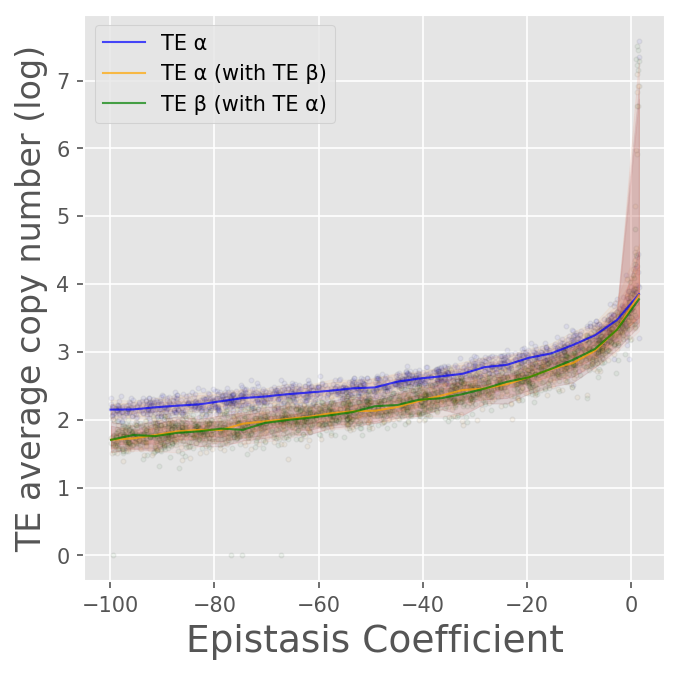

In [112]:
figure(figsize=(5, 5), dpi=150)
plt.clf()
with plt.style.context("ggplot"):
    cols = ["#EE7550", "#F19463", "#F6B176"]
    # plot the 3rd stdv
    plt.fill_between(
        df_1_Alpha.x, df_1_Alpha["5th"], df_1_Alpha["95th"], alpha=0.1, color=cols[2]
    )
    plt.fill_between(
        df_1_Alpha.x, df_1_Alpha["10th"], df_1_Alpha["90th"], alpha=0.1, color=cols[1]
    )
    plt.fill_between(
        df_1_Alpha.x, df_1_Alpha["25th"], df_1_Alpha["75th"], alpha=0.1, color=cols[0]
    )
    # plt the line
    plt.plot(df_1_Alpha.x, df_1_Alpha["median"], color="blue", alpha=0.7, linewidth=1, label="TE α")
    # plot the points
    plt.scatter(
        epistasisCoefficient_1,
        TE_1_ACN_1,
        facecolors="blue",
        edgecolors="0",
        s=5,
        lw=0.7,
        alpha=0.05,
    )

    cols = ["#B31217", "#991014", "#800D11"]
    # plot the 3rd stdv
    plt.fill_between(
        df_2_Alpha.x, df_2_Alpha["5th"], df_2_Alpha["95th"], alpha=0.1, color=cols[2]
    )
    plt.fill_between(
        df_2_Alpha.x, df_2_Alpha["10th"], df_2_Alpha["90th"], alpha=0.1, color=cols[1]
    )
    plt.fill_between(
        df_2_Alpha.x, df_2_Alpha["25th"], df_2_Alpha["75th"], alpha=0.1, color=cols[0]
    )
    # plt the line
    plt.plot(df_2_Alpha.x, df_2_Alpha["median"], color="orange", alpha=0.7, linewidth=1, label="TE α (with TE β)")
    # plot the points
    plt.scatter(
        epistasisCoefficient_2,
        TE_1_ACN_2,
        facecolors="orange",
        edgecolors="0",
        s=5,
        lw=0.7,
        alpha=0.05,
    )

    cols = ["#fa9470", "#daae9d", "#ffa591"]
    # plot the 3rd stdv
    plt.fill_between(
        df_2_Beta.x, df_2_Beta["5th"], df_2_Beta["95th"], alpha=0.1, color=cols[2]
    )
    plt.fill_between(
        df_2_Beta.x, df_2_Beta["10th"], df_2_Beta["90th"], alpha=0.1, color=cols[1]
    )
    plt.fill_between(
        df_2_Beta.x, df_2_Beta["25th"], df_2_Beta["75th"], alpha=0.1, color=cols[0]
    )
    # plt the line
    plt.plot(df_2_Beta.x, df_2_Beta["median"], color="green", alpha=0.7, linewidth=1, label="TE β (with TE α)")
    # plot the points
    plt.scatter(
        epistasisCoefficient_2,
        TE_2_ACN_2,
        facecolors="green",
        edgecolors="0",
        s=5,
        lw=0.7,
        alpha=0.05,
    )
    plt.xlabel('Epistasis Coefficient', fontsize=18)
    plt.ylabel('TE average copy number (log)', fontsize=16)
    plt.legend(loc="upper left")
    plt.show()

In [9]:
# Scatterplot for epi.
TE_1_ACN = resultDataframeC["TE_1_ACN"].tolist()
TE_2_ACN = resultDataframeC["TE_2_ACN"].tolist()
epistasisCoefficient = resultDataframeC["epistasisCoefficient"].tolist()

# Create a DF
plotFrame = pd.DataFrame(
    {
        "TE 1 Copy Number (log)": np.log(TE_1_ACN),
        "Epistasis Coefficient": epistasisCoefficient,
    }
)

# For charting
vmin = min(epistasisCoefficient)
vmax = max(epistasisCoefficient)

In [10]:
# In altair
alt.Chart(plotFrame).mark_circle().encode(
    y="TE 1 Copy Number (log)",
    x="Epistasis Coefficient",
).properties(
    height=800,
    width=800,
    title="TE 1 under epistasis coefficients at generation 4000",
).configure_circle(
    size=400
).configure_axis(
    labelFontSize=20, titleFontSize=25
).configure_title(
    fontSize=30
).configure_legend(
    labelFontSize=20, titleFontSize=25
)

alt.Chart(...)

In [11]:
# Scatterplot for epi.
TE_1_ACN = resultDataframeC["TE_1_ACN_N"].tolist()
TE_2_ACN = resultDataframeC["TE_2_ACN_N"].tolist()
epistasisCoefficient = resultDataframeC["epistasisCoefficient"].tolist()

# Create a DF
plotFrame = pd.DataFrame(
    {
        "TE 1 Copy Number (log)": np.log(TE_1_ACN),
        "Epistasis Coefficient": epistasisCoefficient,
    }
)

# For charting
vmin = min(epistasisCoefficient)
vmax = max(epistasisCoefficient)

In [12]:
# In altair
alt.Chart(plotFrame).mark_circle().encode(
    y="TE 1 Copy Number (log)",
    x="Epistasis Coefficient",
).properties(
    height=800,
    width=800,
    title="TE 1 under different epistasis coefficients at generation 1500",
).configure_circle(
    size=400
).configure_axis(
    labelFontSize=20, titleFontSize=25
).configure_title(
    fontSize=30
).configure_legend(
    labelFontSize=20, titleFontSize=25
)

alt.Chart(...)

In [40]:
# Trying to do watercolor plot
y = plotFrame["TE 1 Copy Number (log)"]
x = plotFrame["Epistasis Coefficient"]
cols = ["#EE7550", "#F19463", "#F6B176"]
df = bin_by(x, y, nbins=25, bins=None)

chart = (
    alt.Chart(df)
    .mark_area(color="#F19463")
    .encode(
        x="x:Q",
        y="5th:Q",
        y2="95th:Q",
    )
)

In [41]:
chart

alt.Chart(...)

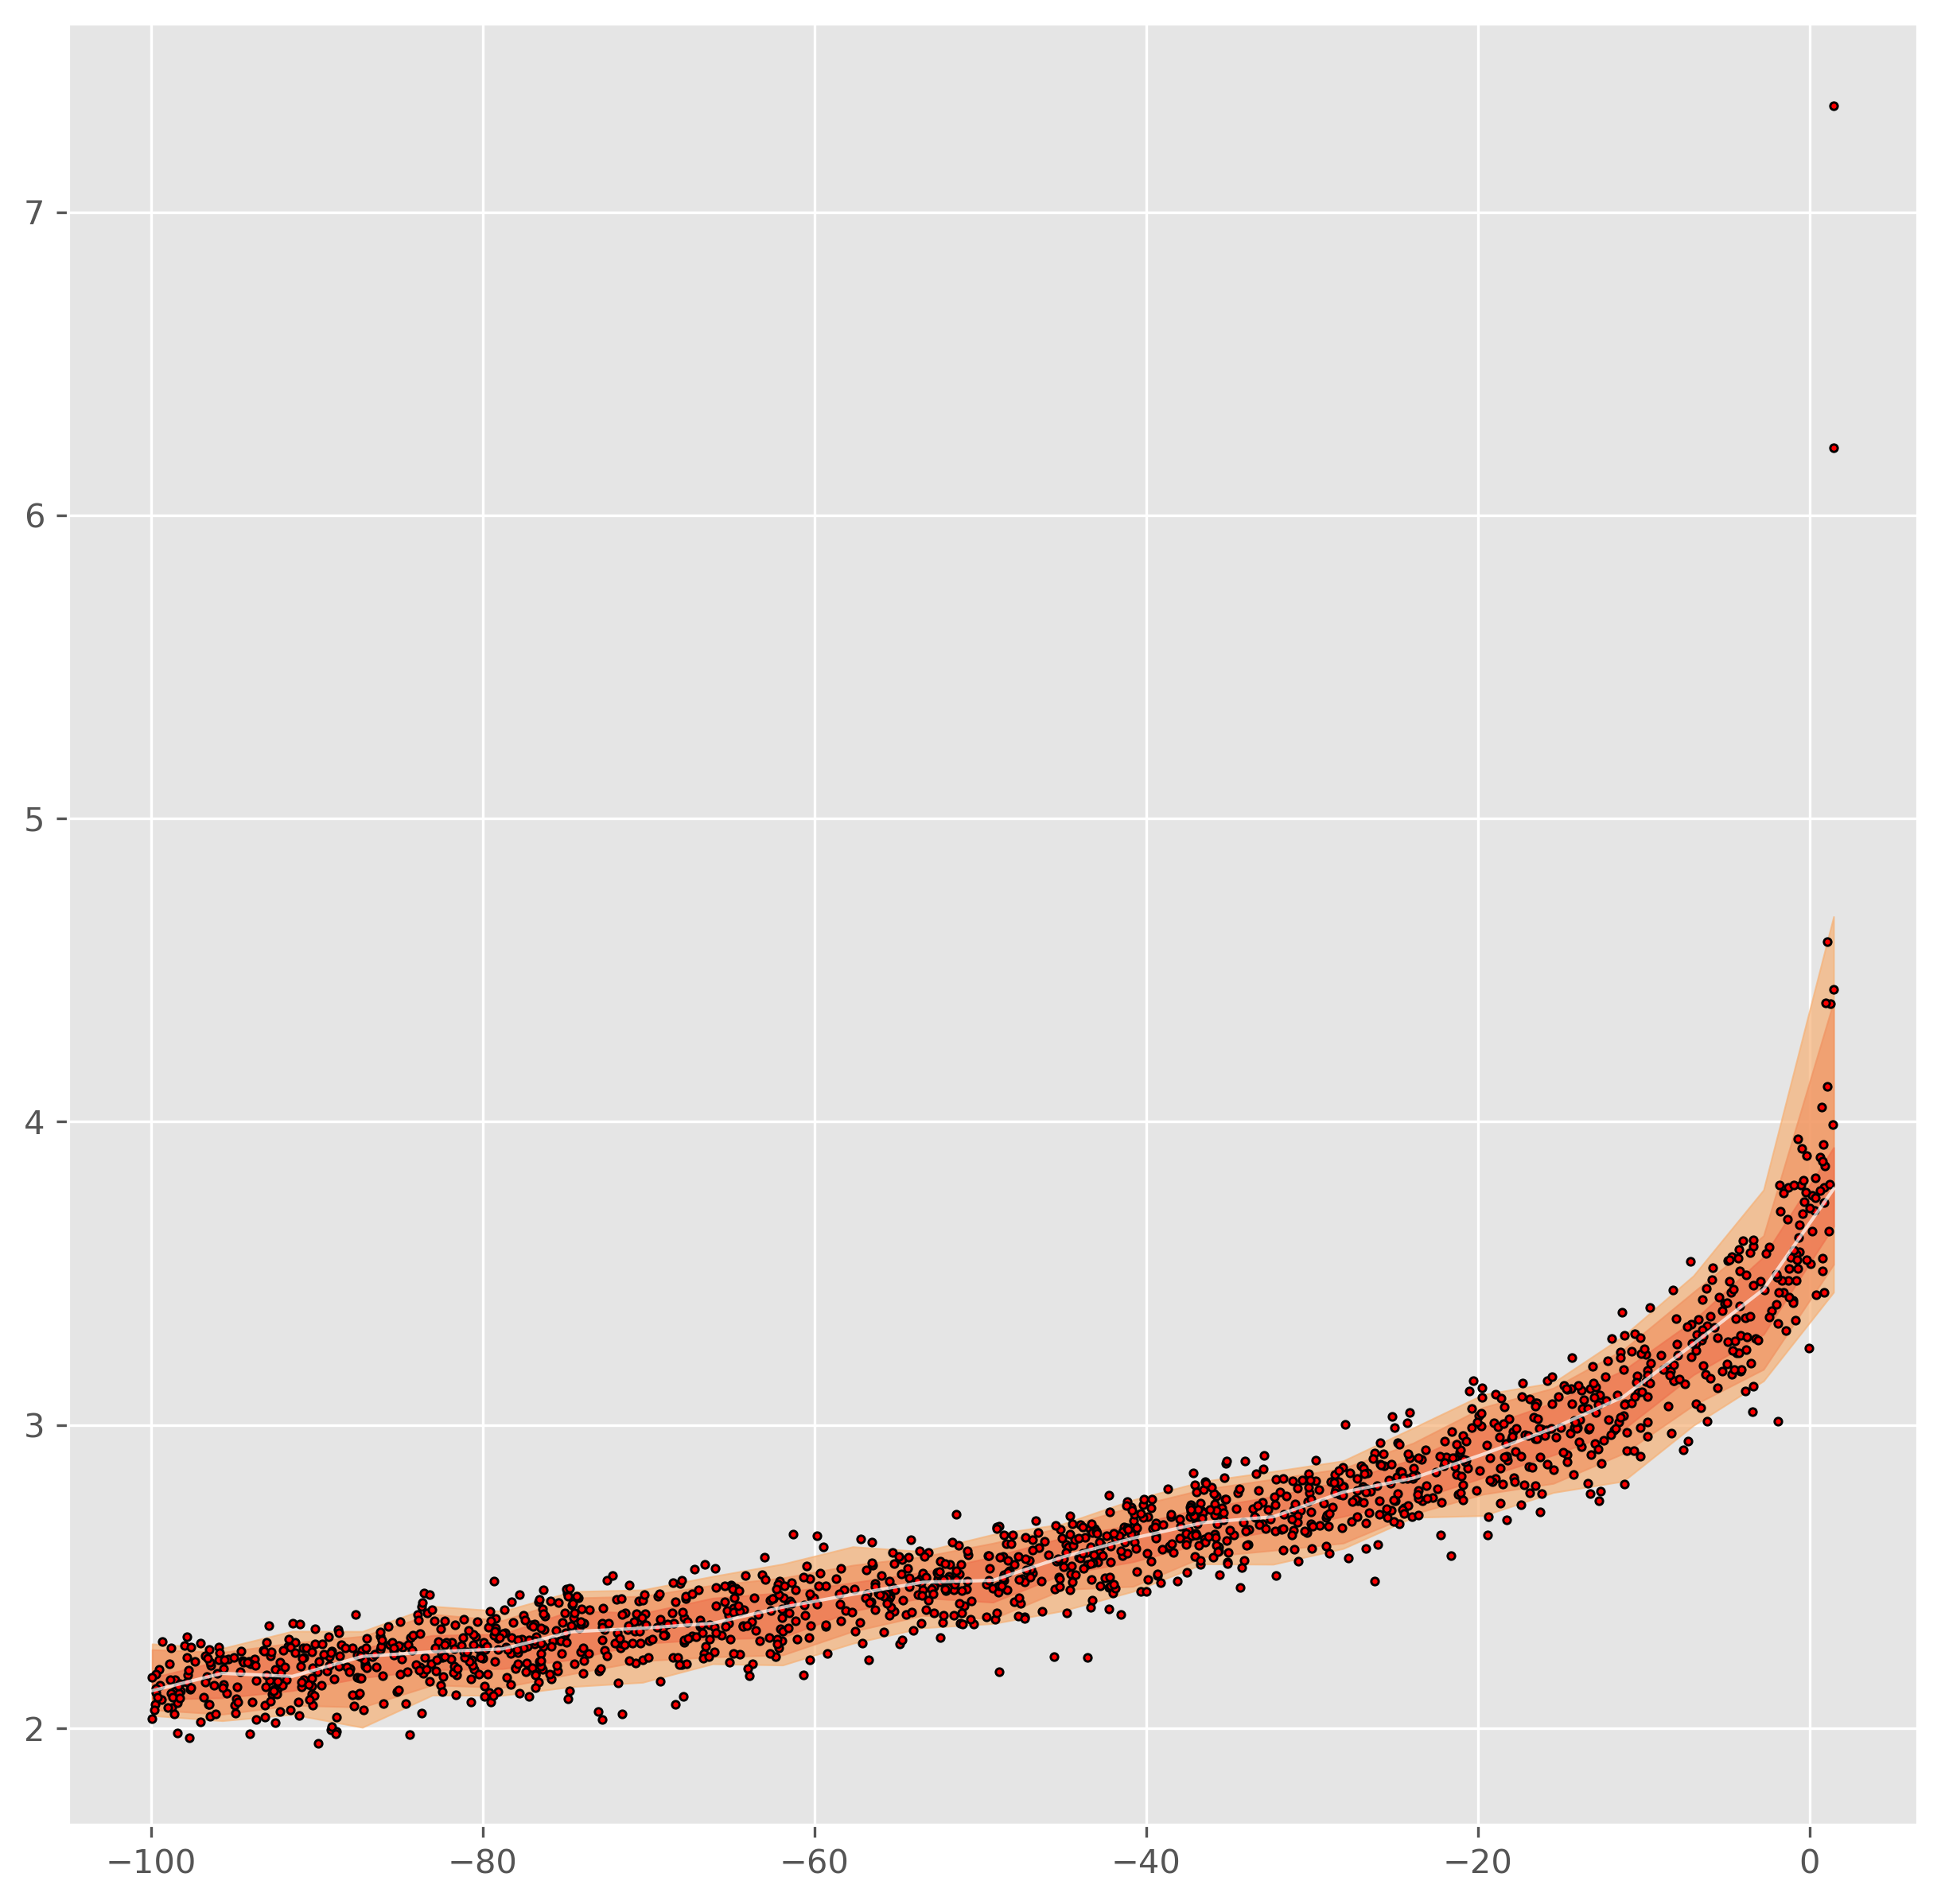

In [32]:
# Trying to do watercolor plot
y = plotFrame["TE 1 Copy Number (log)"]
x = plotFrame["Epistasis Coefficient"]
cols = ["#EE7550", "#F19463", "#F6B176"]
df = bin_by(x, y, nbins=25, bins=None)
figure(figsize=(10, 10), dpi=300)
with plt.style.context("ggplot"):
    # plot the 3rd stdv
    plt.fill_between(df.x, df["5th"], df["95th"], alpha=0.7, color=cols[2])
    plt.fill_between(df.x, df["10th"], df["90th"], alpha=0.7, color=cols[1])
    plt.fill_between(df.x, df["25th"], df["75th"], alpha=0.7, color=cols[0])
    # plt the line
    plt.plot(df.x, df["median"], color="1", alpha=0.7, linewidth=1)
    # plot the points
    plt.scatter(x, y, facecolors="red", edgecolors="0", s=5, lw=0.7)
    plt.show()

In [76]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [20]:
y.min()

AttributeError: 'list' object has no attribute 'min'

In [25]:
df

,mean,median,5th,95th,10th,90th,25th,75th,x
0,2.137724,2.123578,2.041423,2.277856,2.060686,2.258877,2.095069,2.166307,-99.917395
0,2.160995,2.180756,2.024450,2.263210,2.045755,2.249922,2.099792,2.224028,-95.693260
0,2.180389,2.170811,2.045449,2.319812,2.075308,2.280746,2.123723,2.250844,-91.469125
0,2.206900,2.236605,2.002589,2.319105,2.069286,2.303085,2.166421,2.263922,-87.244991
0,2.250965,2.251818,2.108758,2.402068,2.142182,2.375743,2.192435,2.305780,-83.020856
0,2.255701,2.261346,2.108150,2.385639,2.134285,2.355083,2.196224,2.310355,-78.796722
0,2.303382,2.318155,2.137047,2.450624,2.179457,2.429472,2.226598,2.388154,-74.572587
0,2.323841,2.329613,2.151009,2.456031,2.221927,2.434969,2.279316,2.378712,-70.348453
0,2.355776,2.345740,2.212045,2.500694,2.234734,2.471228,2.293645,2.428777,-66.124318
0,2.384112,2.398872,2.208035,2.541542,2.241281,2.495390,2.299555,2.446624,-61.900183
